## Overview
Resnet34 is commonly used as an encoder for U-net and SSD, boosting the model performance and training time since you do not need to train the model from scratch. However, in particular cases it makes sense to do fine-tuning of Resnet34 model before using it as a decoder for object localization or image segmentation. In this competition the size of ship masks is much smaller than the size of images that leads to quite unbalanced training with ~1 positive pixel per 1000 negative ones. If images with no ships are used, instead of ~1:1000 you will end up with ~1:10000 unbalance, which is quite tough. Moreover, the training time is ~4 times longer since you need to process more images in each epoch. So, it is reasonable to drop empty images and focus only on ones with ships. Meanwhile, since the current dataset is quite different from ImageNet, the empty images are quite helpful in fine-tuning your encoder on a pseudo task - ship detection. Moreover, when the training of your U-net or SSD model is completed, you can run the model on images without ships, add false positives (~4000 in my case) as negative example to you training set, and train the model for several additional epochs. Finally, a good model focused on a single task, ship detection, can boost the final score when you stack up it with U-net or SSD. If you predict a ship for an empty image you will get automatically zero score for it, and since PLB has ~85% of empty images, prediction of empty images is quite important.

In this notebook I want to share how to pretrain Resnet34 (or higher end models) on a ship detection task. After training of the head layers of the model on 256x256 rescaled images for one epoch the accuracy has reached 93.7%. The following fine-tuning of entire model for 2 more epochs with learning rate annealing boosted the accuracy to ~97%. If the training is continued for several epochs with a new data set composed of images of 384x384 resolution, the accuracy could be boosted to ~98%. Unfortunately, continuing training the model on full resolution, 768x768, images leaded to reduction of the accuracy that is likely attributed to insufficient model capacity.

In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

/home/yuan/py36env/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Data

In [2]:
PATH = './'
TRAIN = '/mnt/DataStorage/ASDC/train/'
TEST = '/mnt/DataStorage/ASDC/test/'
SEGMENTATION = '/mnt/DataStorage/ASDC/train_ship_segmentations.csv'
#exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
#                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
#                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
#                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted image

In [3]:
nw = 4   #number of workers for data loader
arch = resnet34 #specify target architecture

In [4]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]
#for el in exclude_list:
#    if(el in train_names): train_names.remove(el)
#    if(el in test_names): test_names.remove(el)
#5% of data in the validation set is sufficient for model evaluation
tr_n, val_n = train_test_split(train_names, test_size=0.05, random_state=42)

In [5]:
class pdFilesDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.segmentation_df = pd.read_csv(SEGMENTATION).set_index('ImageId')
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        if self.sz == 768: return img 
        else: return cv2.resize(img, (self.sz, self.sz))
    
    def get_y(self, i):
        if(self.path == TEST): return 0
        masks = self.segmentation_df.loc[self.fnames[i]]['EncodedPixels']
        if(type(masks) == float): return 0 #NAN - no ship 
        else: return 1
    
    def get_c(self): return 2 #number of classes

In [6]:
def get_data(sz,bs):
    #data augmentation
    aug_tfms = [RandomRotate(20, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(pdFilesDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    #md.is_multi = False
    return md

### Model

In [7]:
sz = 256 #image size
bs = 64  #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam

I begin with finding the optimal learning rate. The following function runs training with different lr and records the loss. Increase of the loss indicates onset of divergence of training. The optimal lr lies in the vicinity of the minimum of the curve but before the onset of divergence. Based on the following plot, for the current setup the divergence starts at ~0.01, and the recommended learning rate is ~0.002.

 68%|██████▊   | 1053/1544 [08:03<03:45,  2.18it/s, loss=1.04] 

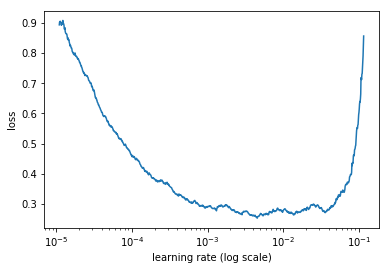

In [8]:
learn.lr_find()
learn.sched.plot()

Training the head part of the model with constant learning rate for one epoch. 

In [9]:
learn.fit(2e-3, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.199008   0.161655   0.936587  


[array([0.16166]), 0.9365872405383515]

Unfreeze the model and train it with differential learning rate. The lr of the head part is still 2e-3, while the middle layers of the model a trained with 5e-4 lr, and the base is trained with even smaller lr, 1e-4, since low level detector do not vary much from one image data set to another.

In [10]:
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

In [11]:
learn.fit(lr, 4, cycle_len=4, use_clr=(20,8))

epoch      trn_loss   val_loss   accuracy                      
    0      0.130259   0.112908   0.957725  
    1      0.117571   0.09652    0.962529                       
    2      0.097379   0.08068    0.971368                       
    3      0.076977   0.065786   0.977709                       
    4      0.098416   0.082472   0.970407                       
    5      0.093352   0.085302   0.972329                       
    6      0.079692   0.065549   0.976556                       
    7      0.072594   0.060336   0.9804                         
    8      0.097222   0.076809   0.972329                       
    9      0.086953   0.065756   0.977517                       
    10     0.071964   0.062491   0.979631                       
    11     0.065646   0.057916   0.9804                         
    12     0.093024   0.067817   0.977709                       
    13     0.071427   0.064289   0.976941                       
    14     0.069527   0.058454   0.980208      

[array([0.05246]), 0.9817448116833205]

The training has been run with learning rate annealing. Periodic lr increase followed by slow decrease drives the system out of steep minima (when lr is high) towards broader ones (which are explored when lr decreases) that enhances the ability of the model to generalize and reduces overfitting. Due to time limit, only once cycle has been run. But ideally several cycles must be run with gradual increase of the image size, etc. 256x256, 384x384, 768x768, to reach better performance of the model.

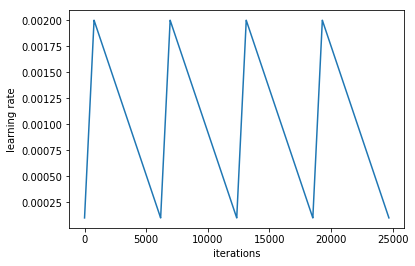

In [12]:
learn.sched.plot_lr()

In [13]:
learn.save('Resnet34_lable_256_1')

### Prediction

In [14]:
log_preds,y = learn.predict_with_targs(is_test=True)
probs = np.exp(log_preds)[:,1]
pred = (probs > 0.5).astype(int)

In [15]:
df = pd.DataFrame({'id':test_names, 'p_ship':probs})
df.to_csv('ship_detection.csv', header=True, index=False)

### Training on high resolution images

Since each epoch on higher resolution images, like 384x384 or 768x768, takes quite long time, training the model from scratch on these images is quite inefficient. Fortunately, modern convolutional nets support input images of arbitrary resolution. To decrease the training time, one can start training the model on low resolution images first and continue training on higher resolution images for only a few epochs. In addition, a model pretrained on low resolution images first generalizes better since a pixel information is less available and high order features are tended to be used.

In [16]:
sz = 384 #image size
bs = 32  #batch size

md = get_data(sz,bs)
learn = ConvLearner.pretrained(arch, md, ps=0.5) #dropout 50%
learn.opt_fn = optim.Adam
learn.unfreeze()
lr=np.array([1e-4,5e-4,2e-3])

In [17]:
learn.load('Resnet34_lable_256_1')

Due to the kernal run time limit, the following code does not have enough time to be executed. I hope it is possible to rerun this kernel with disabled cells from "Model" part and included data from the previous commit to complete training of higher resolution images. Each epoch on images 383x384 takes about 1.5 hours. Probably, some paths, like "learn.models_path", may need to be changed.

In [ ]:
learn.fit(lr/2, 8, cycle_len=4, use_clr=(20,8)) #lr is smaller since bs is only 32
learn.save('Resnet34_lable_384_1')

epoch      trn_loss   val_loss   accuracy                       
    0      0.085956   0.060167   0.980784  
    1      0.090333   0.065881   0.979631                       
    2      0.075847   0.053134   0.981937                       
    3      0.062359   0.050735   0.983282                       
    4      0.073449   0.057654   0.980784                       
    5      0.079316   0.05489    0.982706                       
    6      0.067136   0.053441   0.98309                        
    7      0.061735   0.064699   0.982898                       
    8      0.075954   0.05722    0.98136                        
    9      0.074765   0.054674   0.982513                       
 97%|█████████▋| 3009/3089 [27:10<00:43,  1.85it/s, loss=0.0699]